In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iterative-stratification/iterative-stratification-master/.gitignore
/kaggle/input/iterative-stratification/iterative-stratification-master/LICENSE
/kaggle/input/iterative-stratification/iterative-stratification-master/README.md
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.py
/kaggle/input/iterative-stratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/test_ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/ml_stratifiers.py
/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/k

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/helper-functions')
sys.path.insert(2, '/kaggle/input/iterative-stratification/iterative-stratification-master')

## Import Packages

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.layers import Activation, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils  import plot_model
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

## Helper Functions

In [4]:
def logloss_metric(df, y_true, y_pred):
    
    metrics = []
    
    # Calculate log_loss individually for every field
    for _target in df.columns[1:]:
        metrics.append(log_loss(y_true.loc[:, _target], 
                                y_pred.loc[:, _target].astype(float), 
                                labels=[0,1]))
    
    # Return mean of individual log_loss values
    return np.mean(metrics)

In [5]:
def data_preprocess(train_df, predict_df):
    
    # Display individual dataframe shapes
    print("train_df: {}".format(train_df.shape))
    print("predict_df: {}".format(predict_df.shape))
    train_samples = train_df.shape[0]
    
    # Combined both input dataframes
    combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
    
    # Feature Engineering
    combined_df['sig_id_num'] = combined_df['sig_id'].apply(lambda x: list(map(int, re.findall(r'\d+', x))))
    combined_df['sig_id_num'] = combined_df['sig_id_num'].apply(lambda x: "".join(map(str, x)))
    combined_df['sig_id_num'] = combined_df['sig_id_num'].apply(lambda x: 0 if x=='' else int(x))
    
    combined_df['sig_id_0'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[0]))
    combined_df['sig_id_1'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[1]) if len(str(x))>1 else -1)
    combined_df['sig_id_2'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[2]) if len(str(x))>2 else -1)
    combined_df['sig_id_3'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[3]) if len(str(x))>3 else -1)
    combined_df['sig_id_4'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[4]) if len(str(x))>4 else -1)
    combined_df['sig_id_5'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[5]) if len(str(x))>5 else -1)
    combined_df['sig_id_6'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[6]) if len(str(x))>6 else -1)
    combined_df['sig_id_7'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[7]) if len(str(x))>7 else -1)
    combined_df['sig_id_8'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[8]) if len(str(x))>8 else -1)
    combined_df['sig_id_9'] = combined_df['sig_id_num'].apply(lambda x: int(str(x)[9]) if len(str(x))>9 else -1)
    
    dummy_val = pd.get_dummies(combined_df['cp_type'], prefix='cp_type')
    combined_df = pd.concat([combined_df, dummy_val], axis=1)
    
    dummy_val = pd.get_dummies(combined_df['cp_time'], prefix='cp_time')
    combined_df = pd.concat([combined_df, dummy_val], axis=1)

    combined_df['cp_time_days'] = combined_df['cp_time'].apply(lambda x: x//24)
    dummy_val = pd.get_dummies(combined_df['cp_time_days'], prefix='cp_time_days')
    combined_df = pd.concat([combined_df, dummy_val], axis=1)
    
    dummy_val = pd.get_dummies(combined_df['cp_dose'], prefix='cp_dose')
    combined_df = pd.concat([combined_df, dummy_val], axis=1)

    combined_df.drop(['sig_id', 'sig_id_num', 'cp_type', 'cp_time', 
                      'cp_time_days', 'cp_dose'], axis=1, inplace=True)
    
    # Segregate train and predict datasets
    train_x = combined_df[:train_samples].values
    predict_x = combined_df[train_samples:].values
    print("train_x: {}".format(train_x.shape))
    print("predict_x: {}".format(predict_x.shape))
    
    return train_x, predict_x

## Set file paths for train and predict datasets

In [6]:
train_dataset = "/kaggle/input/lish-moa/train_features.csv"
train_labels_scored = "/kaggle/input/lish-moa/train_targets_scored.csv"
train_labels_unscored = "/kaggle/input/lish-moa/train_targets_nonscored.csv"
predict_dataset = "/kaggle/input/lish-moa/test_features.csv"

## Unscored Labels

### Data Preprocessing

#### Process train and predict features datasets

In [7]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)

print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (23814, 876)
predict_df: (3982, 876)


In [8]:
train_x, predict_x = data_preprocess(train_df, predict_df)

scaler = MinMaxScaler().fit(train_x)
#scaler = StandardScaler().fit(train_x)

train_x = scaler.transform(train_x)
Xpredict = scaler.transform(predict_x)

train_df: (23814, 876)
predict_df: (3982, 876)
train_x: (23814, 892)
predict_x: (3982, 892)


#### Process unscored training labels

In [9]:
train_label_unscored_df = pd.read_csv(train_labels_unscored)
print("train_label_unscored_df: {}".format(train_label_unscored_df.shape))

train_label_unscored_df.drop(['sig_id'], axis=1, inplace=True)
train_label_unscored_df.head()

train_label_unscored_df: (23814, 403)


,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train_y_unscored = train_label_unscored_df.values
print("train_y_unscored: {}".format(train_y_unscored.shape))

train_y_unscored: (23814, 402)


#### Split training data into train/ validation/ test datasets

In [11]:
sss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.085, random_state=10)
for train_index, test_index in sss.split(train_x, train_y_unscored):
    Xtrain, Xtest = train_x[train_index], train_x[test_index]
    Ytrain, Ytest = train_y_unscored[train_index], train_y_unscored[test_index]

In [12]:
Xtrain_DNN = Xtrain.copy()
Xtest_DNN = Xtest.copy()
Xpredict_DNN = Xpredict.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_DNN shape: {}".format(Xtrain_DNN.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_DNN shape: {}".format(Xtest_DNN.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict_DNN shape: {}".format(Xpredict_DNN.shape))

------------------------- Training Dataset -------------------------
Xtrain_DNN shape: (21789, 892)
Ytrain shape: (21789, 402)

------------------------- Test Dataset -------------------------
Xtest_DNN shape: (2025, 892)
Ytest shape: (2025, 402)

------------------------- Prediction Dataset -------------------------
Xpredict_DNN shape: (3982, 892)


In [13]:
Xtrain_CNN = np.expand_dims(Xtrain, axis=2)
Xtest_CNN = np.expand_dims(Xtest, axis=2)
Xpredict_CNN = np.expand_dims(Xpredict, axis=2)

print("------------------------- Training Dataset -------------------------")
print("Xtrain_CNN shape: {}".format(Xtrain_CNN.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_CNN shape: {}".format(Xtest_CNN.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict_CNN shape: {}".format(Xpredict_CNN.shape))

------------------------- Training Dataset -------------------------
Xtrain_CNN shape: (21789, 892, 1)
Ytrain shape: (21789, 402)

------------------------- Test Dataset -------------------------
Xtest_CNN shape: (2025, 892, 1)
Ytest shape: (2025, 402)

------------------------- Prediction Dataset -------------------------
Xpredict_CNN shape: (3982, 892, 1)


### Build the Hybrid model

In [14]:
def hybrid_model(input_shape):
    
    #========================================================================
    #                                DNN Model
    #========================================================================
    
    # Input Layer
    x_input_dnn = Input(shape=(input_shape, ), name='DNN-INPUT')
    
    # Fully-connected Layers
    x_dnn = Dense(units=1024, name='DNN-FC-1', activation='relu', kernel_regularizer=l2(0.001))(x_input_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-1')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-1')(x_dnn)
    
    x_dnn = Dense(units=1024, name='DNN-FC-2', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-2')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-2')(x_dnn)

    x_dnn = Dense(units=1024, name='DNN-FC-3', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-3')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-3')(x_dnn)

    x_dnn = Dense(units=512, name='DNN-FC-4', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-4')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-4')(x_dnn)
    
    x_dnn = Dense(units=512, name='DNN-FC-5', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-5')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-5')(x_dnn)
    
    x_dnn = Dense(units=512, name='DNN-FC-6', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-6')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-6')(x_dnn)
    
    #========================================================================
    #                                 CNN Model
    #========================================================================
    
    # Input Layer
    x_input_cnn = Input(shape=(input_shape, 1), name='CNN-INPUT')

    # Convolutional Layers
    x_cnn = Conv1D(filters=16, kernel_size=5, strides=2, padding='same', 
               activation='relu', name='CONV-1', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.001))(x_input_cnn)
    x_cnn = BatchNormalization(name='BN_CONV-1')(x_cnn)
    x_cnn = MaxPool1D(pool_size=2, name='MAXPOOL-1')(x_cnn)
    x_cnn = Dropout(rate=0.25, name='DROPOUT_CONV-1')(x_cnn)

    x_cnn = Conv1D(filters=32, kernel_size=5, strides=2, padding='same', 
               activation='relu', name='CONV-2', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='BN_CONV-2')(x_cnn)
    x_cnn = MaxPool1D(pool_size=2, name='MAXPOOL-2')(x_cnn)
    x_cnn = Dropout(rate=0.25, name='DROPOUT_CONV-2')(x_cnn)

    x_cnn = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
               activation='relu', name='CONV-3', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='BN_CONV-3')(x_cnn)
    x_cnn = MaxPool1D(pool_size=2, name='MAXPOOL-3')(x_cnn)
    x_cnn = Dropout(rate=0.25, name='DROPOUT_CONV-3')(x_cnn)
    
    # Fully-connected Layers
    x_cnn = Flatten(name='FLATTEN')(x_cnn)
    x_cnn = Dense(units=1024, name='CNN-FC-1', activation='relu', kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='CNN-BN_FC-1')(x_cnn)
    x_cnn = Dropout(rate=0.5, name='CNN-DROPOUT_FC-1')(x_cnn)
    
    x_cnn = Dense(units=1024, name='CNN-FC-2', activation='relu', kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='CNN-BN_FC-2')(x_cnn)
    x_cnn = Dropout(rate=0.5, name='CNN-DROPOUT_FC-2')(x_cnn)

    x_cnn = Dense(units=512, name='CNN-FC-3', activation='relu', kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='CNN-BN_FC-3')(x_cnn)
    x_cnn = Dropout(rate=0.5, name='CNN-DROPOUT_FC-3')(x_cnn)

    x_cnn = Dense(units=512, name='CNN-FC-4', activation='relu', kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='CNN-BN_FC-4')(x_cnn)
    x_cnn = Dropout(rate=0.5, name='CNN-DROPOUT_FC-4')(x_cnn)
    
    #========================================================================
    #                    Combining outputs from both models
    #========================================================================
    
    x = Concatenate()([x_dnn, x_cnn])
    x = Activation('relu')(x)
    x = Dropout(rate=0.5, name='DROPOUT_COMBINED')(x)
    
    x = Dense(units=1024, name='COMBINED-FC-1', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='COMBINED-BN_FC-1')(x)
    x = Dropout(rate=0.5, name='COMBINED-DROPOUT_FC-1')(x)
    
    x = Dense(units=1024, name='COMBINED-FC-2', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='COMBINED-BN_FC-2')(x)
    x = Dropout(rate=0.5, name='COMBINED-DROPOUT_FC-2')(x)
    
    # Output Layer
    x = Dense(units=402, activation='sigmoid', name='OUTPUT')(x)

    # Create Keras Model instance
    model = Model(inputs=[x_input_dnn, x_input_cnn], outputs=x, name='Hybrid_Model_Unscored')

    return model

In [15]:
# Define the model hyperparameters
mini_batch_size = 256
min_lr = 1e-5
max_lr = 3e-3
step_size = 4 * (Xtrain.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [16]:
# Create the model
model = hybrid_model(Xtrain.shape[1])

# Compile model to configure the learning process
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-3))

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
               mode=clr_method, step_size=step_size)

In [17]:
model.summary()

Model: "Hybrid_Model_Unscored"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CNN-INPUT (InputLayer)          [(None, 892, 1)]     0                                            
__________________________________________________________________________________________________
CONV-1 (Conv1D)                 (None, 446, 16)      96          CNN-INPUT[0][0]                  
__________________________________________________________________________________________________
BN_CONV-1 (BatchNormalization)  (None, 446, 16)      64          CONV-1[0][0]                     
__________________________________________________________________________________________________
MAXPOOL-1 (MaxPooling1D)        (None, 223, 16)      0           BN_CONV-1[0][0]                  
______________________________________________________________________________

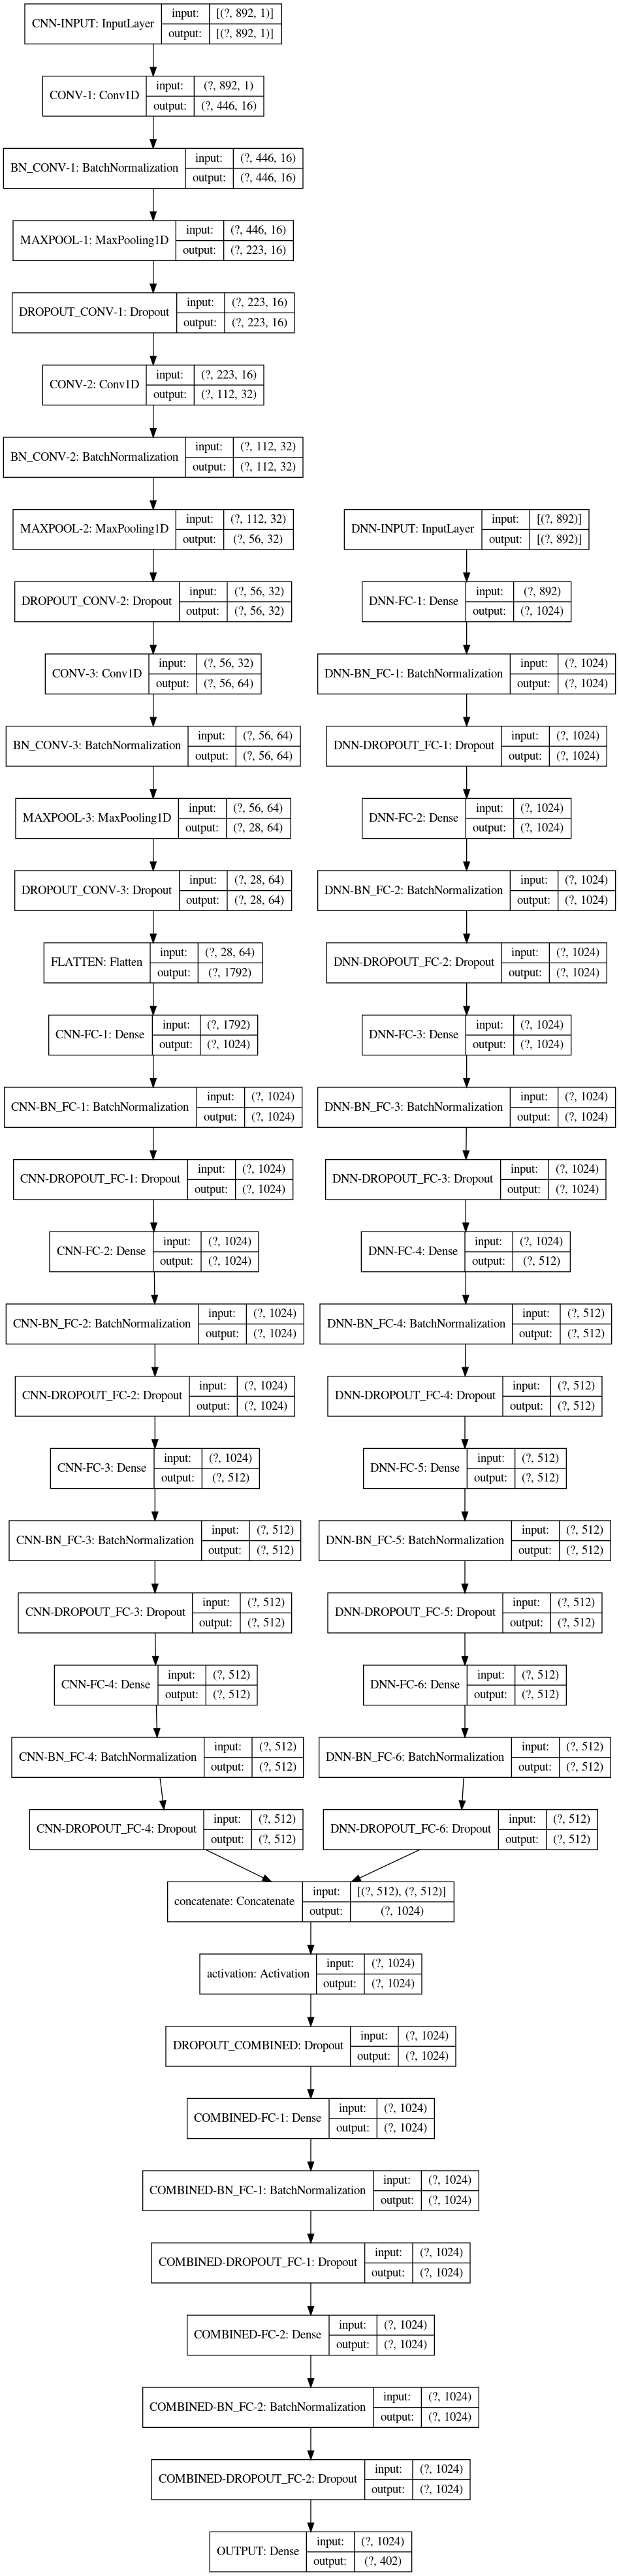

In [18]:
plot_model(model, to_file='/kaggle/working/unscored_labels_hybrid_model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
'''
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find(([Xtrain_DNN, Xtrain_CNN], Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()
'''

'\n# Learning Rate Finder\nlrf = LearningRateFinder(model)\nlrf.find(([Xtrain_DNN, Xtrain_CNN], Ytrain),\n         startLR=1e-10, endLR=1e-1,\n         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),\n         batchSize=mini_batch_size)\nlrf.plot_loss()\nplt.grid()\nplt.show()\n'

In [20]:
# Define K-fold cross validation test harness
kfold = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=10)
y_pred = 0
y_pred_final = 0
idx = 0

for train, val in kfold.split(Xtrain, Ytrain):
    idx += 1
    print("---------------- Fold {} ----------------".format(idx))
    
    train_x_dnn, val_x_dnn = Xtrain_DNN[train], Xtrain_DNN[val]
    train_x_cnn, val_x_cnn = Xtrain_CNN[train], Xtrain_CNN[val]
    train_y, val_y = Ytrain[train], Ytrain[val]
    
    # Create the model
    model = hybrid_model(Xtrain.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=1e-3))

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
                   mode=clr_method, step_size=step_size)
    
    # Fit the model
    history = model.fit(x=[train_x_dnn, train_x_cnn], y=train_y, batch_size=mini_batch_size,
                        epochs=125, verbose=1,
                        callbacks=[clr], workers=5,
                        validation_data=([val_x_dnn, val_x_cnn], val_y))
    
    # Make predictions
    pred = model.predict([Xtest_DNN, Xtest_CNN])
    y_pred += pred
    
    pred_final = model.predict([Xpredict_DNN, Xpredict_CNN])
    y_pred_final += pred_final

y_pred /= float(idx)
y_pred_final /= float(idx)

---------------- Fold 1 ----------------
Epoch 1/125
77/77 [==============================] - 2s 27ms/step - loss: 9.5548 - val_loss: 6.1220
Epoch 2/125
77/77 [==============================] - 2s 20ms/step - loss: 3.0746 - val_loss: 1.2590
Epoch 3/125
77/77 [==============================] - 2s 21ms/step - loss: 0.6522 - val_loss: 0.3631
Epoch 4/125
77/77 [==============================] - 1s 19ms/step - loss: 0.5162 - val_loss: 0.3834
Epoch 5/125
77/77 [==============================] - 1s 19ms/step - loss: 0.6199 - val_loss: 0.2802
Epoch 6/125
77/77 [==============================] - 1s 18ms/step - loss: 0.1281 - val_loss: 0.0810
Epoch 7/125
77/77 [==============================] - 1s 19ms/step - loss: 0.5055 - val_loss: 0.2441
Epoch 8/125
77/77 [==============================] - 1s 19ms/step - loss: 0.1609 - val_loss: 0.1143
Epoch 9/125
77/77 [==============================] - 1s 19ms/step - loss: 0.1016 - val_loss: 0.0960
Epoch 10/125
77/77 [==============================] - 2s 21

#### Validate the model

In [21]:
true_labels = pd.DataFrame(Ytest, columns=train_label_unscored_df.columns)
pred_labels = pd.DataFrame(y_pred, columns=train_label_unscored_df.columns)
logloss_metric(train_label_unscored_df, true_labels, pred_labels)

0.004891109355215597

In [22]:
y_pred_final = (y_pred_final >= 0.5).astype(int)
print(y_pred_final.shape)

(3982, 402)


#### Learning Curves

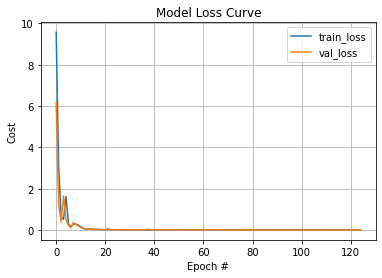

In [23]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

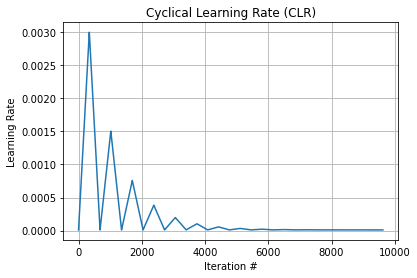

In [24]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

## Scored Labels

### Data Preprocessing

#### Process train and predict features datasets

In [25]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
train_label_unscored_df = pd.read_csv(train_labels_unscored)

print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))
print("train_label_unscored_df: {}".format(train_label_unscored_df.shape))

train_df: (23814, 876)
predict_df: (3982, 876)
train_label_unscored_df: (23814, 403)


In [26]:
train_df = pd.merge(train_df, train_label_unscored_df, 
                    how='inner', on='sig_id')
print("train_df: {}".format(train_df.shape))
train_df.head()

train_df: (23814, 1278)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0,0,0,0,0,0,0,0,0,0


In [27]:
pred_labels_unscored_df = pd.DataFrame(y_pred_final, columns=train_label_unscored_df.columns[1:])
pred_labels_unscored_df['sig_id'] = predict_df['sig_id']
pred_labels_unscored_df.head()

,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,...,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor,sig_id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_0004d9e33
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_001897cda
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_002429b5b
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_00276f245
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,id_0027f1083


In [28]:
predict_df = pd.merge(predict_df, pred_labels_unscored_df, 
                      how='inner', on='sig_id')
print("predict_df: {}".format(predict_df.shape))
predict_df.head()

predict_df: (3982, 1278)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0,0,0,0,0,0,0,0,0,0
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,0,0,0,0,0,0,0,0,0,0
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,0,0,0,0,0,0,0,0,0,0
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0,0,0,0,0,0,0,0,0,0
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0,0,0,0,0,0,0,0,0,0


In [29]:
train_x, predict_x = data_preprocess(train_df, predict_df)

scaler = MinMaxScaler().fit(train_x)
#scaler = StandardScaler().fit(train_x)
#scaler = RobustScaler().fit(train_x)

train_x = scaler.transform(train_x)
Xpredict = scaler.transform(predict_x)

train_df: (23814, 1278)
predict_df: (3982, 1278)
train_x: (23814, 1294)
predict_x: (3982, 1294)


#### Process scored training labels

In [30]:
train_label_df = pd.read_csv(train_labels_scored)
print("train_label_df: {}".format(train_label_df.shape))

train_label_df.drop(['sig_id'], axis=1, inplace=True)
train_label_df.head()

train_label_df: (23814, 207)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
train_y = train_label_df.values
print("train_y: {}".format(train_y.shape))

train_y: (23814, 206)


#### Split training data into train/ validation/ test datasets

In [32]:
sss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.085, random_state=20)
for train_index, test_index in sss.split(train_x, train_y):
    Xtrain, Xtest = train_x[train_index], train_x[test_index]
    Ytrain, Ytest = train_y[train_index], train_y[test_index]

In [33]:
Xtrain_DNN = Xtrain.copy()
Xtest_DNN = Xtest.copy()
Xpredict_DNN = Xpredict.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_DNN shape: {}".format(Xtrain_DNN.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_DNN shape: {}".format(Xtest_DNN.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict_DNN shape: {}".format(Xpredict_DNN.shape))

------------------------- Training Dataset -------------------------
Xtrain_DNN shape: (21789, 1294)
Ytrain shape: (21789, 206)

------------------------- Test Dataset -------------------------
Xtest_DNN shape: (2025, 1294)
Ytest shape: (2025, 206)

------------------------- Prediction Dataset -------------------------
Xpredict_DNN shape: (3982, 1294)


In [34]:
Xtrain_CNN = np.expand_dims(Xtrain, axis=2)
Xtest_CNN = np.expand_dims(Xtest, axis=2)
Xpredict_CNN = np.expand_dims(Xpredict, axis=2)

print("------------------------- Training Dataset -------------------------")
print("Xtrain_CNN shape: {}".format(Xtrain_CNN.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest_CNN shape: {}".format(Xtest_CNN.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict_CNN shape: {}".format(Xpredict_CNN.shape))

------------------------- Training Dataset -------------------------
Xtrain_CNN shape: (21789, 1294, 1)
Ytrain shape: (21789, 206)

------------------------- Test Dataset -------------------------
Xtest_CNN shape: (2025, 1294, 1)
Ytest shape: (2025, 206)

------------------------- Prediction Dataset -------------------------
Xpredict_CNN shape: (3982, 1294, 1)


### Build the CNN model

In [35]:
def hybrid_model(input_shape):
    
    #========================================================================
    #                                DNN Model
    #========================================================================
    
    # Input Layer
    x_input_dnn = Input(shape=(input_shape, ), name='DNN-INPUT')
    
    # Fully-connected Layers
    x_dnn = Dense(units=1024, name='DNN-FC-1', activation='relu', kernel_regularizer=l2(0.001))(x_input_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-1')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-1')(x_dnn)
    
    x_dnn = Dense(units=1024, name='DNN-FC-2', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-2')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-2')(x_dnn)

    x_dnn = Dense(units=512, name='DNN-FC-3', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-3')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-3')(x_dnn)

    x_dnn = Dense(units=512, name='DNN-FC-4', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-4')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-4')(x_dnn)
    
    x_dnn = Dense(units=512, name='DNN-FC-5', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-5')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-5')(x_dnn)
    
    x_dnn = Dense(units=256, name='DNN-FC-6', activation='relu', kernel_regularizer=l2(0.001))(x_dnn)
    x_dnn = BatchNormalization(name='DNN-BN_FC-6')(x_dnn)
    x_dnn = Dropout(rate=0.5, name='DNN-DROPOUT_FC-6')(x_dnn)
    
    #========================================================================
    #                                 CNN Model
    #========================================================================
    
    # Input Layer
    x_input_cnn = Input(shape=(input_shape, 1), name='CNN-INPUT')

    # Convolutional Layers
    x_cnn = Conv1D(filters=16, kernel_size=5, strides=2, padding='same', 
               activation='relu', name='CONV-1', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.001))(x_input_cnn)
    x_cnn = BatchNormalization(name='BN_CONV-1')(x_cnn)
    x_cnn = MaxPool1D(pool_size=2, name='MAXPOOL-1')(x_cnn)
    x_cnn = Dropout(rate=0.25, name='DROPOUT_CONV-1')(x_cnn)

    x_cnn = Conv1D(filters=32, kernel_size=5, strides=2, padding='same', 
               activation='relu', name='CONV-2', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='BN_CONV-2')(x_cnn)
    x_cnn = MaxPool1D(pool_size=2, name='MAXPOOL-2')(x_cnn)
    x_cnn = Dropout(rate=0.25, name='DROPOUT_CONV-2')(x_cnn)

    x_cnn = Conv1D(filters=64, kernel_size=5, strides=2, padding='same', 
               activation='relu', name='CONV-3', kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='BN_CONV-3')(x_cnn)
    x_cnn = MaxPool1D(pool_size=2, name='MAXPOOL-3')(x_cnn)
    x_cnn = Dropout(rate=0.25, name='DROPOUT_CONV-3')(x_cnn)
    
    # Fully-connected Layers
    x_cnn = Flatten(name='FLATTEN')(x_cnn)
    x_cnn = Dense(units=1024, name='CNN-FC-1', activation='relu', kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='CNN-BN_FC-1')(x_cnn)
    x_cnn = Dropout(rate=0.5, name='CNN-DROPOUT_FC-1')(x_cnn)
    
    x_cnn = Dense(units=512, name='CNN-FC-2', activation='relu', kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='CNN-BN_FC-2')(x_cnn)
    x_cnn = Dropout(rate=0.5, name='CNN-DROPOUT_FC-2')(x_cnn)

    x_cnn = Dense(units=512, name='CNN-FC-3', activation='relu', kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='CNN-BN_FC-3')(x_cnn)
    x_cnn = Dropout(rate=0.5, name='CNN-DROPOUT_FC-3')(x_cnn)

    x_cnn = Dense(units=256, name='CNN-FC-4', activation='relu', kernel_regularizer=l2(0.001))(x_cnn)
    x_cnn = BatchNormalization(name='CNN-BN_FC-4')(x_cnn)
    x_cnn = Dropout(rate=0.5, name='CNN-DROPOUT_FC-4')(x_cnn)
    
    #========================================================================
    #                    Combining outputs from both models
    #========================================================================
    
    x = Concatenate()([x_dnn, x_cnn])
    x = Activation('relu')(x)
    x = Dropout(rate=0.5, name='DROPOUT_COMBINED')(x)
    
    x = Dense(units=512, name='COMBINED-FC-1', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='COMBINED-BN_FC-1')(x)
    x = Dropout(rate=0.5, name='COMBINED-DROPOUT_FC-1')(x)
    
    x = Dense(units=512, name='COMBINED-FC-2', activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization(name='COMBINED-BN_FC-2')(x)
    x = Dropout(rate=0.5, name='COMBINED-DROPOUT_FC-2')(x)
    
    # Output Layer
    x = Dense(units=206, activation='sigmoid', name='OUTPUT')(x)

    # Create Keras Model instance
    model = Model(inputs=[x_input_dnn, x_input_cnn], outputs=x, name='Hybrid_Model_Unscored')

    return model

In [36]:
# Define the model hyperparameters
mini_batch_size = 256
min_lr = 1e-5
max_lr = 3e-3
step_size = 4 * (Xtrain.shape[0] // mini_batch_size)
clr_method = 'triangular2'

In [37]:
# Create the model
model = hybrid_model(Xtrain.shape[1])

# Compile model to configure the learning process
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=1e-3))

# Triangular learning rate policy
clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
               mode=clr_method, step_size=step_size)

In [38]:
model.summary()

Model: "Hybrid_Model_Unscored"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
CNN-INPUT (InputLayer)          [(None, 1294, 1)]    0                                            
__________________________________________________________________________________________________
CONV-1 (Conv1D)                 (None, 647, 16)      96          CNN-INPUT[0][0]                  
__________________________________________________________________________________________________
BN_CONV-1 (BatchNormalization)  (None, 647, 16)      64          CONV-1[0][0]                     
__________________________________________________________________________________________________
MAXPOOL-1 (MaxPooling1D)        (None, 323, 16)      0           BN_CONV-1[0][0]                  
______________________________________________________________________________

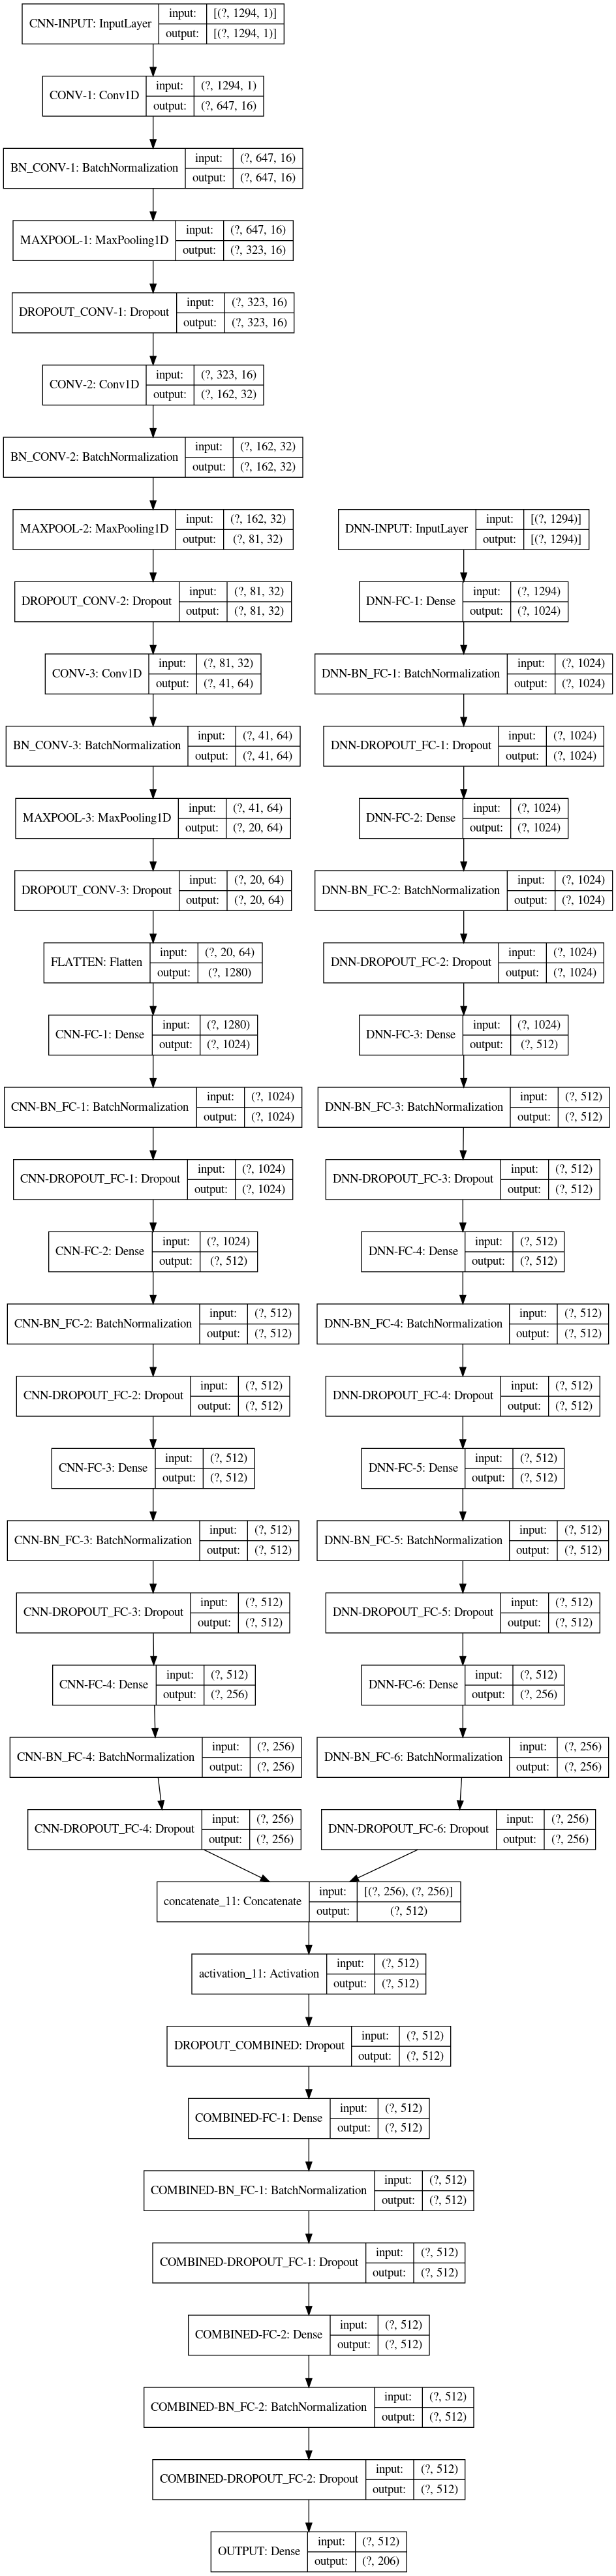

In [39]:
plot_model(model, to_file='/kaggle/working/scored_labels_hybrid_model_plot.png', show_shapes=True, show_layer_names=True)

In [40]:
'''
# Learning Rate Finder
lrf = LearningRateFinder(model)
lrf.find(([Xtrain_DNN, Xtrain_CNN], Ytrain),
         startLR=1e-10, endLR=1e-1,
         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),
         batchSize=mini_batch_size)
lrf.plot_loss()
plt.grid()
plt.show()
'''

'\n# Learning Rate Finder\nlrf = LearningRateFinder(model)\nlrf.find(([Xtrain_DNN, Xtrain_CNN], Ytrain),\n         startLR=1e-10, endLR=1e-1,\n         stepsPerEpoch=np.ceil((len(Xtrain) / float(mini_batch_size))),\n         batchSize=mini_batch_size)\nlrf.plot_loss()\nplt.grid()\nplt.show()\n'

In [41]:
# Define K-fold cross validation test harness
kfold = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=20)
y_pred = 0
y_pred_final = 0
idx = 0

for train, val in kfold.split(Xtrain, Ytrain):
    idx += 1
    print("---------------- Fold {} ----------------".format(idx))
    
    train_x_dnn, val_x_dnn = Xtrain_DNN[train], Xtrain_DNN[val]
    train_x_cnn, val_x_cnn = Xtrain_CNN[train], Xtrain_CNN[val]
    train_y, val_y = Ytrain[train], Ytrain[val]
    
    # Create the model
    model = hybrid_model(Xtrain.shape[1])

    # Compile model to configure the learning process
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr=1e-3))

    # Triangular learning rate policy
    clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, 
                   mode=clr_method, step_size=step_size)
    
    # Fit the model
    history = model.fit(x=[train_x_dnn, train_x_cnn], y=train_y, batch_size=mini_batch_size,
                        epochs=125, verbose=1,
                        callbacks=[clr], workers=5,
                        validation_data=([val_x_dnn, val_x_cnn], val_y))
    
    # Make predictions
    pred = model.predict([Xtest_DNN, Xtest_CNN])
    y_pred += pred
    
    pred_final = model.predict([Xpredict_DNN, Xpredict_CNN])
    y_pred_final += pred_final

y_pred /= float(idx)
y_pred_final /= float(idx)

---------------- Fold 1 ----------------
Epoch 1/125
77/77 [==============================] - 2s 27ms/step - loss: 7.9406 - val_loss: 5.8134
Epoch 2/125
77/77 [==============================] - 2s 21ms/step - loss: 3.5229 - val_loss: 1.4949
Epoch 3/125
77/77 [==============================] - 2s 22ms/step - loss: 0.8048 - val_loss: 0.3256
Epoch 4/125
77/77 [==============================] - 2s 22ms/step - loss: 0.3442 - val_loss: 0.3689
Epoch 5/125
77/77 [==============================] - 2s 22ms/step - loss: 0.1537 - val_loss: 0.5106
Epoch 6/125
77/77 [==============================] - 2s 20ms/step - loss: 0.9876 - val_loss: 0.4833
Epoch 7/125
77/77 [==============================] - 2s 20ms/step - loss: 0.3046 - val_loss: 0.2020
Epoch 8/125
77/77 [==============================] - 2s 20ms/step - loss: 0.1644 - val_loss: 0.1398
Epoch 9/125
77/77 [==============================] - 2s 20ms/step - loss: 0.1296 - val_loss: 0.1269
Epoch 10/125
77/77 [==============================] - 1s 19

#### Validate the model

In [42]:
true_labels = pd.DataFrame(Ytest, columns=train_label_df.columns)
pred_labels = pd.DataFrame(y_pred, columns=train_label_df.columns)
logloss_metric(train_label_df, true_labels, pred_labels)

0.015836071424641416

#### Learning Curves

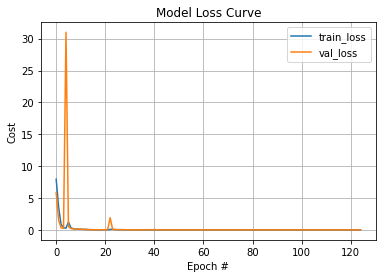

In [43]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylabel('Cost')
plt.xlabel('Epoch #')
plt.title("Model Loss Curve")
plt.legend()
plt.grid()
plt.show()

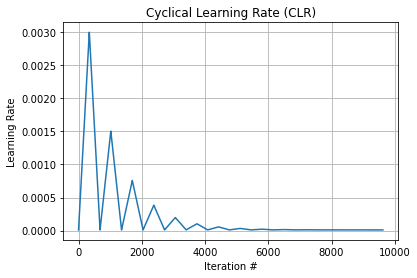

In [44]:
plt.plot(clr.history["lr"])
plt.ylabel('Learning Rate')
plt.xlabel('Iteration #')
plt.title("Cyclical Learning Rate (CLR)")
plt.grid()
plt.show()

## Create submission file

In [45]:
pred_labels = pd.DataFrame(y_pred_final, columns=train_label_df.columns)
print(pred_labels.shape)
pred_labels.head()

(3982, 206)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0.000695,0.000555,0.001251,0.011236,0.017303,0.003590,0.002388,0.005227,0.000569,0.015525,...,3.171105e-04,0.000914,0.002543,0.001915,0.004504,3.199999e-04,0.004515,0.001454,0.002324,0.001359
1,0.000870,0.001043,0.001314,0.005336,0.006074,0.003037,0.002193,0.004140,0.001167,0.008464,...,4.885746e-04,0.002707,0.002127,0.005030,0.009728,4.174178e-04,0.012176,0.001167,0.002340,0.001548
2,0.000003,0.000005,0.000005,0.000060,0.000087,0.000018,0.000021,0.000031,0.000002,0.000115,...,7.930365e-07,0.000008,0.000010,0.000153,0.000059,8.421680e-07,0.000160,0.000004,0.000009,0.000018
3,0.000417,0.000458,0.000790,0.003701,0.005349,0.001411,0.001145,0.002481,0.000353,0.005220,...,2.032924e-04,0.001438,0.001206,0.013721,0.009314,2.015865e-04,0.015619,0.000734,0.001075,0.000675
4,0.000866,0.000702,0.001549,0.013433,0.019894,0.004583,0.003012,0.006312,0.000692,0.018653,...,3.726236e-04,0.001110,0.003176,0.002339,0.002348,3.773611e-04,0.002640,0.001697,0.002558,0.001591


In [46]:
submit_df = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")
submit_df.loc[:, submit_df.columns != 'sig_id'] = pred_labels
submit_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000695,0.000555,0.001251,0.011236,0.017303,0.003590,0.002388,0.005227,0.000569,...,3.171105e-04,0.000914,0.002543,0.001915,0.004504,3.199999e-04,0.004515,0.001454,0.002324,0.001359
1,id_001897cda,0.000870,0.001043,0.001314,0.005336,0.006074,0.003037,0.002193,0.004140,0.001167,...,4.885746e-04,0.002707,0.002127,0.005030,0.009728,4.174178e-04,0.012176,0.001167,0.002340,0.001548
2,id_002429b5b,0.000003,0.000005,0.000005,0.000060,0.000087,0.000018,0.000021,0.000031,0.000002,...,7.930365e-07,0.000008,0.000010,0.000153,0.000059,8.421680e-07,0.000160,0.000004,0.000009,0.000018
3,id_00276f245,0.000417,0.000458,0.000790,0.003701,0.005349,0.001411,0.001145,0.002481,0.000353,...,2.032924e-04,0.001438,0.001206,0.013721,0.009314,2.015865e-04,0.015619,0.000734,0.001075,0.000675
4,id_0027f1083,0.000866,0.000702,0.001549,0.013433,0.019894,0.004583,0.003012,0.006312,0.000692,...,3.726236e-04,0.001110,0.003176,0.002339,0.002348,3.773611e-04,0.002640,0.001697,0.002558,0.001591


In [47]:
submit_df.to_csv("/kaggle/working/submission.csv", index=False)